In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
# read the data
df = pd.read_csv("D:\\LogAI\\Teydeb_Proje_OnCalisma.csv")

In [5]:
df.drop(['Unnamed: 0'], axis=1,inplace=True)
df.drop(['Timestamp'], axis=1,inplace=True)

In [6]:
# replace +ve and -ve infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)
df = df.replace([np.nan], 0)

### DataFrame' in Model için Hazırlanması

In [7]:
X = df.drop(columns=['Label'])
X = X.astype('float32')
y = df['Label']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (4525399, 78)
Shape of y: (4525399,)


In [8]:
min_max = MinMaxScaler(feature_range=(0,1))
X[X.columns] = min_max.fit_transform(X[X.columns])

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [10]:
Counter(y)

Counter({0: 2856035, 3: 1289544, 2: 513, 5: 53, 4: 93063, 1: 286191})

### SMOTE ile Sentetik Veri Üretimi

In [10]:
counter = Counter(y_train)
print("Before: ", counter)

desired_samples = {
    2: 93063,  
    5: 93063,  
    4: 93063
}
sampling_strategy = {label: desired_samples[label] for label in desired_samples if label in counter}
smt = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

X_train_sm,y_train_sm = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm)
print("After: ", counter)

Before:  Counter({0: 2284725, 3: 1031872, 1: 228909, 4: 74370, 2: 405, 5: 38})
After:  Counter({0: 2284725, 3: 1031872, 1: 228909, 4: 93063, 2: 93063, 5: 93063})


### Model Geliştirme

In [13]:
import time

model = RandomForestClassifier(n_estimators=279, max_depth=7, n_jobs = -1)

# Eğitim süresini ölçün
start_time = time.time()
model.fit(X_train_sm, y_train_sm)
end_time = time.time()

print(f"Model eğitimi {end_time - start_time:.2f} saniye sürdü.")

Model eğitimi 702.99 saniye sürdü.


In [14]:
start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()

print(f"Tahmin süresi {end_time - start_time:.2f} saniye sürdü.")

Tahmin süresi 12.20 saniye sürdü.


### Model Değerlendirmesi

Accuracy: 0.98
Error_rate: 0.02
Precision: 0.82
Recall: 0.74


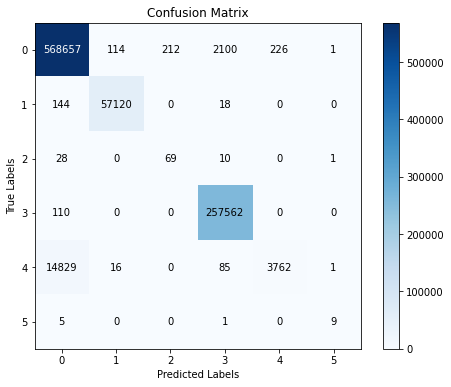

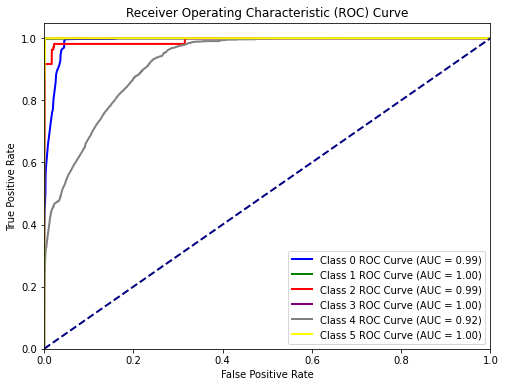

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report


accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

error_rate = 1 - accuracy
print(f'Error_rate: {error_rate:.2f}')

# Precision değeri hesaplama. 
precision = precision_score(y_test, predictions, average='macro')
print(f'Precision: {precision:.2f}')

# Recall değeri hesaplama 
recall = recall_score(y_test, predictions, average='macro')
print(f'Recall: {recall:.2f}')

# Confusion matrix plotlama.
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(conf_matrix.shape[1]), np.arange(conf_matrix.shape[1]))
plt.yticks(np.arange(conf_matrix.shape[0]), np.arange(conf_matrix.shape[0]))

# Confusion matrix'e değerleri ekleme.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# ROC eğrisi ve ROC AUC score hesaplama ve plotlama.
y_prob = model.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_prob.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, y_prob[:, i])

# Tüm sınıfların ROC eğrilerini plotlama.
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red','purple','gray','yellow']
for i, color in zip(range(y_prob.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} ROC Curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_acc(y_test,y_pred):

    cm = confusion_matrix(y_test, y_pred)

    # Her sınıf için accuracy hesaplama
    class_accuracies = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        accuracy = TP / (TP + FN) if (TP + FN) != 0 else 0
        if(accuracy >= 1):
            accuracy = 0.99
        class_accuracies.append(accuracy)

    # Sınıfların etiketleri
    class_labels = ['Benign', 'Bot', 'Brute Force', 'DoS', 'Infiltration', 'SQL Injection']

    # Sütun grafiği oluşturma
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_accuracies, color='skyblue')
    plt.xlabel('Sınıflar')
    plt.ylabel('Accuracy')
    plt.title('Sınıf Bazında Accuracy')
    plt.ylim(0, 1)  # Y eksenini 0-1 arasında sınırla (accuracy 0-100%)
    plt.xticks(rotation=45)  # Sınıf etiketlerini 45 derece döndür

    # Her sütunun üzerine accuracy değerlerini yazma
    for i, acc in enumerate(class_accuracies):
        plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

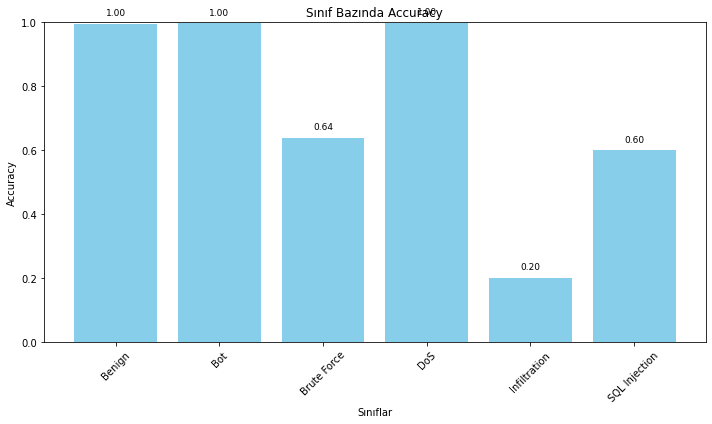

In [18]:
plot_acc(y_test,predictions)